Test the modules and functions of modelval

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [21]:
data[data['ptl_idx']==1].head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0


Test KernelGen object

In [22]:
from modelval.kernel import KernelGen

In [23]:
ker_test = KernelGen()

AttributeError: 'KernelGen' object has no attribute 'bilat_ker'

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


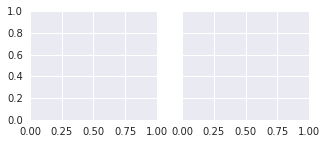

In [24]:
fig, ax = plt.subplots(1,2, sharex=True,sharey=True)
fig.set_figwidth(5)
fig.set_figheight(2)
ax[0].plot(ker_test.x, ker_test.bilat_ker)
ax[0].set_xlim(-50, 50)
uni_ker = ker_test.uni_exp_ker()
ax[1].plot(ker_test.x, ker_test.unilat_ker)

Test KernelGen function

In [ ]:
from modelval.ArbDataGen import arb_spk_gen

In [ ]:
test_ptl = PairPtl(*data.iloc[10])
spk_time_pre, spk_time_post, spk_pair = arb_spk_gen(test_ptl, ker_test.reso_kernel, if_noise=1)

In [ ]:
spk_time_pre

In [25]:
spk_time_post

NameError: name 'spk_time_post' is not defined

In [26]:
plt.plot(spk_time_pre[:20], np.ones(20), '.', label='Pre')
plt.plot(spk_time_post[:20], np.ones(20), '.', label='Post')
plt.legend()
#plt.axis([0,200,0.9,1.1])

NameError: name 'spk_time_pre' is not defined

Test dataset

In [27]:
from modelval.dataset import Dataset

In [28]:
x = np.random.normal(loc=0.0, scale=1.0, size=[10000,10])

In [29]:
w_true = np.ones(shape=(10,1)) * 0.5
y_true = np.dot(x, w_true)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_vali, y_train, y_vali = train_test_split(x, y_true, test_size=0.1)

In [32]:
train_data = Dataset(X_train, y_train)

In [33]:
vali_data = Dataset(X_vali, y_vali)

Test network class

In [34]:
from modelval.network import BaseNet

In [35]:
# Build the basic network
basenet = BaseNet()

In [36]:
from modelval.trainer import Trainer

In [41]:
basenet_train = Trainer(basenet.loss, input_name=basenet.X, target_name=basenet.y, save_dir='/src/Plasticity_Ker/model/',  optimizer_config={'learning_rate': basenet.lr})

In [42]:
learning_rate = 0.001
iterations = 100
for i in range(iterations):
    # test_net.train(train_data, vali_data, feed_dict={lr: learning_rate, l1: 0.001, l2: 0.001})
    basenet_train.train(train_data, vali_data, feed_dict={basenet.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=1012.64301
Global Step 0150 and Step 0150: validation cost=2647.74219
Global Step 0200 and Step 0200: validation cost=2297.55151
Global Step 0250 and Step 0250: validation cost=1990.05151
Global Step 0300 and Step 0300: validation cost=1718.94116
Global Step 0350 and Step 0350: validation cost=1484.91150
Global Step 0400 and Step 0400: validation cost=1278.63184
Global Step 0450 and Step 0450: validation cost=1098.34131
Global Step 0500 and Step 0500: validation cost=941.36652
Updated min validation loss!Saving model...
Global Step 0550 and Step 0550: validation cost=806.45996
Updated min validation loss!Saving model...
Global Step 0600 and Step 0600: validation cost=688.63629
Updated min validation loss!Saving model...
Global Step 0650 and Step 0650: validation cost=587.06665
Updated min validation loss!Saving model...
Global Step 0700 and Step 0700: validation cost=499.60553
Updated min validation loss!Saving model...
Global Step 0750 and Step 0750: validatio

KeyboardInterrupt: 

In [34]:
w_hat = basenet_train.evaluate(ops=basenet.w)

In [35]:
w_hat

array([[0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5],
       [0.5]], dtype=float32)

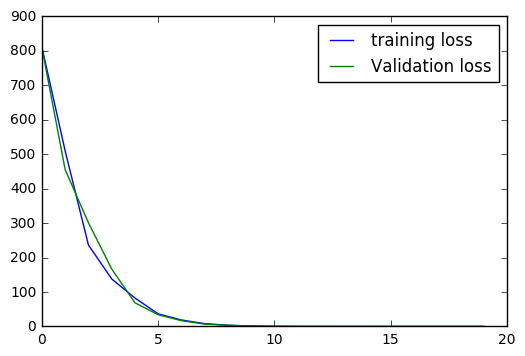

In [36]:
loss = np.vstack(basenet_train.loss_tracker)
plt.plot(loss[:20,0], label = 'training loss')
plt.plot(loss[:20,1], label = 'Validation loss')
plt.legend()

Test PairNet

In [41]:
from modelval.network import PairNet

In [42]:
# Create arbitrary spike train to validate the restuls
spk_train = np.zeros((30000, 2))
spk_train[1000, :] = 1
spk_train = spk_train.reshape([1, 30000, 2])

In [44]:
pairnet_test = PairNet(kernel=ker_test, n_input=spk_train.shape[1], kernel_pre=ker_test.bilat_ker, kernel_post=ker_test.unilat_ker)

In [45]:
pairnet_test_train = Trainer(pairnet_test.prediction, input_name=pairnet_test.inputs)

In [46]:
test_ptl = PairPtl(*data.iloc[10])
spk_time_pre, spk_time_post, spk_pair = arb_spk_gen(test_ptl, ker_test.reso_kernel, if_noise=1)
spk_pair = spk_pair.reshape([1, 30000, 2])

In [47]:
pairnet_test_train.evaluate(ops=pairnet_test.prediction, inputs=spk_train)

array([[[4.946867]]], dtype=float32)

In [49]:
np.sum(np.multiply(ker_test.bilat_ker, ker_test.unilat_ker))

4.946866897552985

Test generating batch spike trains

In [50]:
from modelval.kernel import KernelGen
ker_test = KernelGen()

In [51]:
from modelval.ArbDataGen import arb_w_gen

In [52]:
spk_pairs, targets = arb_w_gen(df=data, ptl_list=[1], kernel=ker_test, aug_times=1)

In [53]:
spk_pairs.shape

(45, 150000, 2)

In [54]:
targets.shape

(45, 1, 1)